# Importy, wizualizacja
(Należy odpalić i schować).

In [32]:
%matplotlib inline

import torch

from torch import nn
from torch.utils.data import Subset
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Lambda, Compose

import matplotlib.pyplot as plt

import numpy as np

from sklearn.decomposition import PCA

def plot_dataset(train_data, model):
    view_data = train_data.data[:5].view(-1, 28*28) / 255.
    _, decoded_data = model.forward(train_data.data[:5].view(-1, 784).float().cuda() / 255.)
    decoded_data = decoded_data.cpu().detach().numpy()

    n_rows = 2 if decoded_data is not None else 1
    n_cols = len(view_data)
    plt.suptitle("Reconstruction")
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    
    if decoded_data is not None:
        for i in range(n_cols):
            axes[0][i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray')
            axes[0][i].set_xticks(())
            axes[0][i].set_yticks(())
        
        for i in range(n_cols):
            axes[1][i].clear()
            axes[1][i].imshow(np.reshape(decoded_data[i], (28, 28)), cmap='gray')
            axes[1][i].set_xticks(())
            axes[1][i].set_yticks(())
    
    else:
        for i in range(n_cols):
            axes[i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray')
            axes[i].set_xticks(())
            axes[i].set_yticks(())
    
    plt.show()

def plot_pca(data, model):
    labels = data.classes
    plt.suptitle("Reduction of latent space")
    _ = plt.figure(figsize=(10, 6))
    pca = PCA(2)

    z = model.encode(train_data.data.view(-1, 784).float().cuda())
    reduced_z = pca.fit_transform(z.detach().cpu().numpy())
    
    for class_idx in range(10):
        indices = (data.targets == class_idx)
        plt.scatter(
            reduced_z[indices, 0], reduced_z[indices, 1],
            s=2., label=labels[class_idx])

    plt.legend()
    plt.show()


torch.manual_seed(1337) 
batch_size = 128 
transforms = Compose([ToTensor(), Lambda(lambda x: x.flatten())])

# Mnist dataset
train_data = MNIST(root='.', 
                   train=True, 
                   transform=transforms,    
                   download=True) # change to false if you already have the data

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

# Auoenkoder i modele generatywne

Na dzisiejszych zajęciach poznamy model autoenkodera i pokażemy, kolejno:
1. Jak jego ukrytą reprezentację można wykorzystać do uczenia częściowo nadzorowanego
2. Jak można wymusić na autoenkoderze generatywność i "zmusić" go do generowania nowych przykładów podobnych do tych ze zbioru treningowego.


## Podstawowy autoenkoder

![Auto-encoder](https://raw.githubusercontent.com/gmum/ml2022-23/master/lab/resources/ae.png)

Autoenkoder rozumiemy jako sieć neuronową, która na wyjściu ma odtwarzać ten sam obiekt, który dostaje na wejściu. Zazwyczaj na autoenkoder patrzymy jako na połączenie dwóch modeli: enkodera $\mathcal{E}$ i dekodera $\mathcal{D}$. Interpretujemy działanie modelu w następujący sposób: enkoder kompresuje wejściowy przykład $x$ do wektora $y$, o którym myślimy jako o reprezentacji ukrytej. Dekoder na podstawie wektora $y$ produkuje $\hat{x}$, które ma aproksymować oryginalne wejście $x$. Tzn.:

$$
y = \mathcal{E} x 
$$
$$
\hat{x} = \mathcal{D} y
$$

Funkcją kosztu w autoenkoderze będzie MSE pomiędzy wejściem a wyjściem:
$$
\mathcal{L}_{AE} =\frac{1}{n}\sum_i \|x_i-\mathcal{D}\mathcal{E} x_i\|_2^2,
$$
 

Enkoder i dekoder mogą być dowolnymi sieciami neuronowymi, najczęściej jednak dekoder składa się z tych samych transformacji co enkoder w odwrotnej kolejności.  

## Zadanie 1. Vanilla Autoencoder (1 pkt.)

Należy zaimplementować enkoder i dekoder. Kolejne warstwy w enkoderze mają mieć następującą liczbę neuronów: [784, 128, 128, 64, `latent_dim`]. Analogicznie dekoder ma wyglądać następująco: [`latent_dim`, 64, 128, 128, 784]. Wejście i wyjście mają 784 neurony, jako że taka jest wymiarowość MNIST-a. Wartość `latent_dim` dostajemy na wejściu do konstruktora (`latent_dim`).

Po warstwach ukrytych chcemy mieć aktywacje ReLU, **na końcu enkodera nie stosujemy żadnej aktywacji**, na końcu dekodera stosujemy aktywację sigmoidalną.

**Pytanie: Dlaczego na końcu dekodera chcemy mieć sigmoidę?**

In [33]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, latent_dim):
        
        super(AutoEncoder, self).__init__()
        
        self.latent_dim = latent_dim
        
        D = latent_dim
        self.encoder = torch.nn.Sequential(torch.nn.Linear(784, 128),
                            torch.nn.ReLU(),
                            torch.nn.Linear(128, 128),
                            torch.nn.ReLU(),
                            torch.nn.Linear(128, 64),
                            torch.nn.ReLU(),
                            torch.nn.Linear(64, D))

        self.decoder = torch.nn.Sequential(torch.nn.Linear(D, 64),
                            torch.nn.ReLU(),
                            torch.nn.Linear(64, 128),
                            torch.nn.ReLU(),
                            torch.nn.Linear(128, 128),
                            torch.nn.ReLU(),
                            torch.nn.Linear(128, 784),
                            torch.nn.Sigmoid())
        
    def decode(self, encoded):
        return self.decoder(encoded)
    
    def encode(self, x):
        return self.encoder(x)

    def forward(self, x):
        # encode and decode
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return encoded, decoded

Epoch: 0  |  train loss: 0.0519


<Figure size 640x480 with 0 Axes>

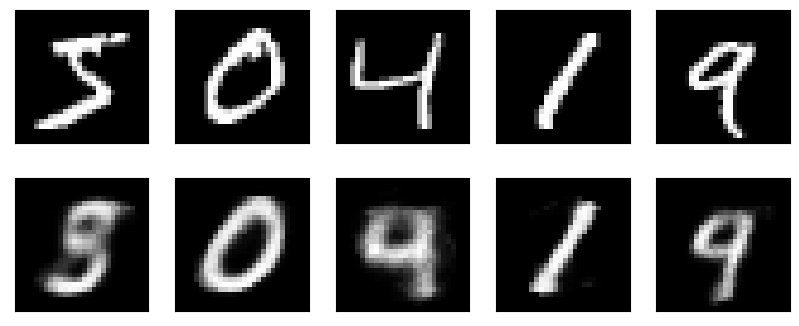

<Figure size 640x480 with 0 Axes>

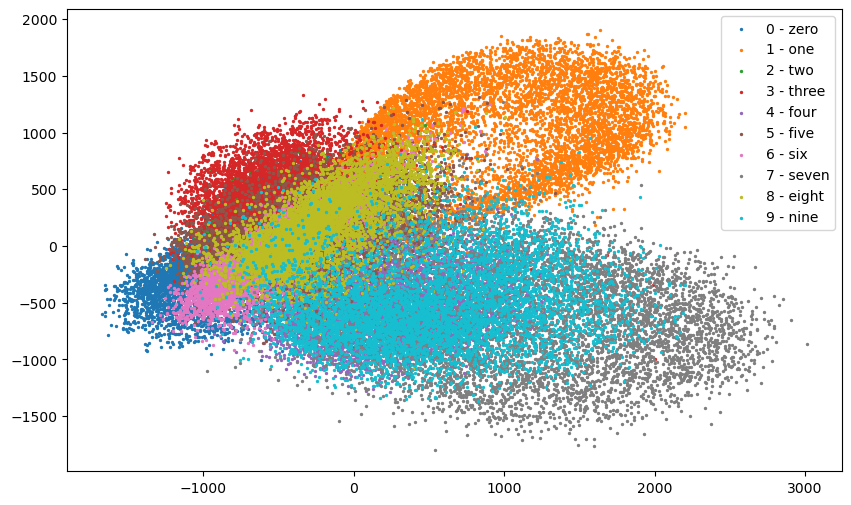

Epoch: 1  |  train loss: 0.0314
Epoch: 2  |  train loss: 0.0255
Epoch: 3  |  train loss: 0.0228
Epoch: 4  |  train loss: 0.0213
Epoch: 5  |  train loss: 0.0200
Epoch: 6  |  train loss: 0.0189
Epoch: 7  |  train loss: 0.0180
Epoch: 8  |  train loss: 0.0175
Epoch: 9  |  train loss: 0.0170
Epoch: 10  |  train loss: 0.0167


<Figure size 640x480 with 0 Axes>

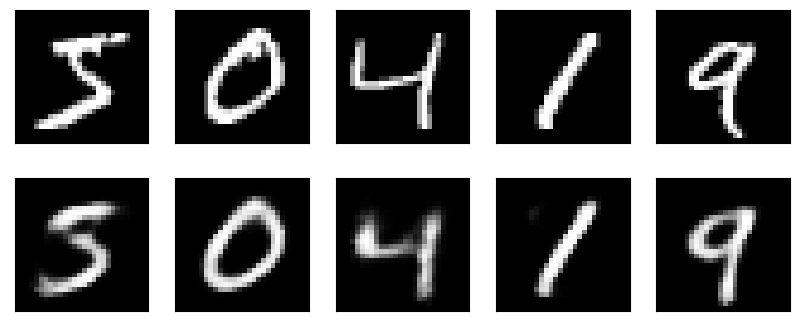

<Figure size 640x480 with 0 Axes>

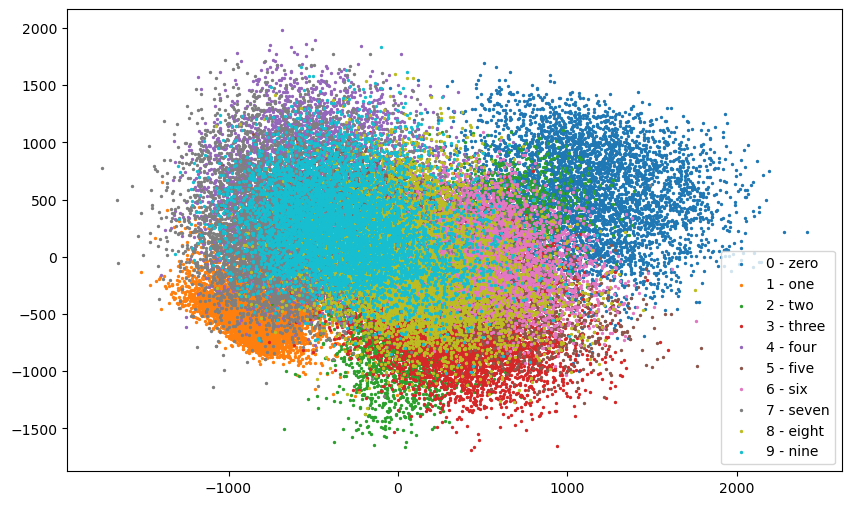

Epoch: 11  |  train loss: 0.0166
Epoch: 12  |  train loss: 0.0163
Epoch: 13  |  train loss: 0.0161
Epoch: 14  |  train loss: 0.0160
Epoch: 15  |  train loss: 0.0159
Epoch: 16  |  train loss: 0.0158
Epoch: 17  |  train loss: 0.0157
Epoch: 18  |  train loss: 0.0156
Epoch: 19  |  train loss: 0.0155
Epoch: 20  |  train loss: 0.0155


<Figure size 640x480 with 0 Axes>

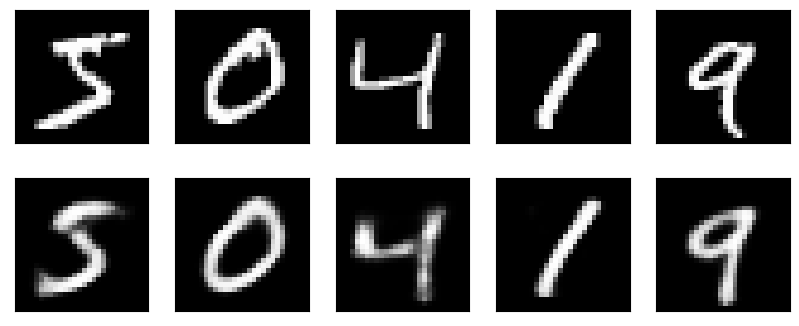

<Figure size 640x480 with 0 Axes>

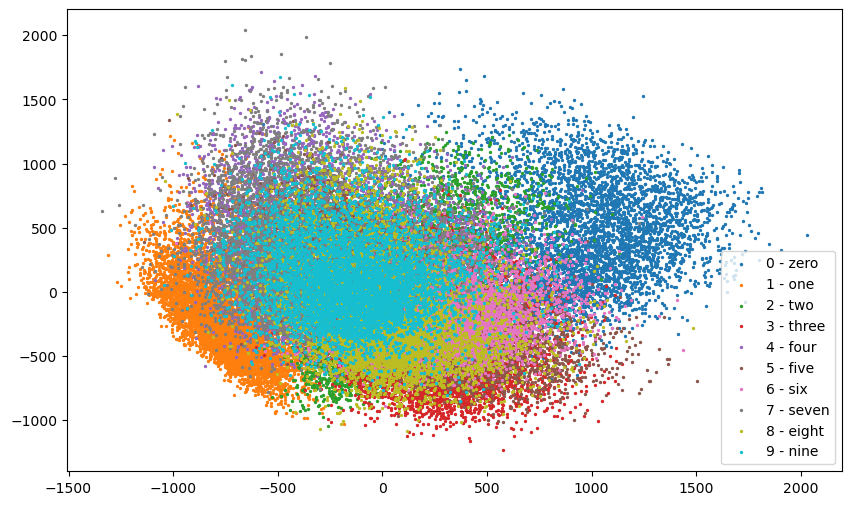

Epoch: 21  |  train loss: 0.0153
Epoch: 22  |  train loss: 0.0153
Epoch: 23  |  train loss: 0.0152
Epoch: 24  |  train loss: 0.0152


In [35]:
# Hyper Parameters
epochs = 25
LR = 5e-3         # learning rate

# prepare original data for plotting

autoencoder = AutoEncoder(latent_dim=10).cuda()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
rec_loss_fn = torch.nn.MSELoss()

for epoch in range(epochs):
    epoch_losses = []  # For logging purposes
    for step, (x, y) in enumerate(train_loader):
        x = x.cuda()
        y = y.cuda()
        encoded, decoded = autoencoder(x)
        loss_val = rec_loss_fn(decoded, x) # calculate loss
        optimizer.zero_grad()        # clear gradients for this training step
        loss_val.backward()          # backpropagation, compute gradients
        optimizer.step()             # apply gradients
        
        epoch_losses.append(loss_val.item())

    print(f'Epoch: {epoch}  |  train loss: {np.mean(epoch_losses):.4f}')

    if epoch % 10 == 0:
        plot_dataset(train_data, autoencoder)
        plot_pca(train_data, autoencoder)

## Część 1: Uczenie częściowo nadzorowane (semi-supervised learning)

W praktyce zbudowanie w pełni nadzorowanego zbioru danych często jest kosztowne. Jeżeli chcielibyśmy uczyć się klasyfikacji obrazków naturalnych, to zdobycie dużych zbiorów danych nie jest trudne (możemy je zescrapować z internetu), natomiast zdobycie do nich etykiet wymagałoby czasu człowieka, który zidentyfikowałby, co się znajduje na poszczególnych obrazkach. W niektórych przypadkach etykietowanie jest jeszcze bardziej kosztowne - w zagadnieniu segmentacji, gdzie chcemy każdemu pikselowi w obrazku przypisać jedną klasę, zapisanie etykiety dla jednego obrazka może zająć ekspertowi kilka godzin.

Problem liczby etykiet i ich jakości jest w praktyce bardzo istotny. Dlatego też w praktyce chcielibyśmy mieć metody głębokiego uczenia, które potrafią wykorzystać dane, dla których nie mamy etykiet. W poniższym przykładzie zbudujemy prosty model częściowo nadzorowany z wykorzystaniem autoenkodera.


## Zadanie 2. Uczenie częściowo nadzorowane (3 pkt.)

Załóżmy, że z 60.000 przykładów zbiorze MNIST tylko 100 przykładów ma podaną etykietę, a dla pozostałych 59.900 nie mamy etykiety - tym samym mamy problem uczenia częściowo nadzorowanego. Nasze 100 przykładów z etykietami zdefiniowane są w zmiennej `labeled_data`.

1. Zaimplementuj i wytrenuj sieć neuronową (klasyfikator), która uczy się wyłącznie bezpośrednio na 100 podanych przykładach. Po **wytrenowaniu wypisz accuracy na zbiorze testowym, jaki udało Ci się uzyskać**. Sieć powinna być względnie mała (max 4 warstwy, max 128 neuronów w warstwie). Zapisz wynik.
2. Zaimplementuj i wytrenuj sieć neuronową (klasyfikator) o podobnej architekturze co w poprzednim punkcie, również na datasecie 100 przykładów, ale tym razem niech wejściem do sieci będzie ukryta reprezentacja $y = \mathcal{E}x$ stworzona przez autoenkoder wytrenowany w Zadaniu 1. Zapisz wynik.
3. Porównaj wyniki obu modeli. Wskaż, który nauczył się lepiej i podaj hipotezę dlaczego.


In [ ]:
labeled_data = Subset(train_data, range(100))
labeled_loader = torch.utils.data.DataLoader(dataset=labeled_data, batch_size=32, shuffle=True)

test_data = MNIST(root='.', 
                   train=False, 
                   transform=transforms,    
                   download=True) # change to false if you already have the data
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=5000, shuffle=True)

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
device = torch.device(device)

cuda:0


In [39]:
from datetime import datetime

### Tutaj zaimplementuj i wytrenuj model baseline'owy
model = torch.nn.Sequential(torch.nn.Linear(784, 128),
                            torch.nn.ReLU(),
                            torch.nn.Linear(128, 64),
                            torch.nn.ReLU(),
                            torch.nn.Linear(64, 10),
                            torch.nn.Sigmoid())

# Hyper Parameters
epochs = 25
LR = 5e-3         # learning rate

model = model.to(device)

# prepare original data for plotting

def acc(predictions, labels):
    classes = torch.argmax(predictions, dim=1)
    return torch.mean((classes == labels).float())

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = torch.nn.CrossEntropyLoss()



for epoch in range(epochs):
    logs = {}
    total_correct = 0
    total_loss = 0
    total_images = 0
    total_val_loss = 0

    model.train()
    for step, (x, y) in enumerate(labeled_loader):
        x = x.to(device)
        y = y.to(device)
        outputs = model(x)
        loss = loss_fn(outputs, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_images+= y.size(0)

        _, predicted = torch.max(outputs.detach(), 1)



        # Calculate the number of correct answers
        correct = (predicted == y).sum().item()

        total_correct+=correct
        total_loss+=loss.item()

    logs['log loss'] = total_loss / total_images
    logs['Accuracy'] = ((total_correct / total_images) * 100)


    print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, epochs,
                      (total_loss / total_images),
                      (total_correct / total_images) * 100))
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        total_losss =0

        for (x, y) in test_loader:
            x = x.to(device)
            y = y.to(device)
            outputs = model(x)
            _, predicted = torch.max(outputs.detach(), 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
            total_losss += loss.item()

            accuracy = correct / total

        print('Test Accuracy of the model: {} %'.format(100 * correct / total))
        logs['val_' + 'log loss'] = total_losss/total
        logs['val_' + 'Accuracy'] = ((correct / total) * 100)


Epoch [1/25], Loss: 0.0908, Accuracy: 19.00%
Test Accuracy of the model: 18.48 %
Epoch [2/25], Loss: 0.0853, Accuracy: 28.00%
Test Accuracy of the model: 38.12 %
Epoch [3/25], Loss: 0.0794, Accuracy: 62.00%
Test Accuracy of the model: 51.45 %
Epoch [4/25], Loss: 0.0719, Accuracy: 78.00%
Test Accuracy of the model: 57.61 %
Epoch [5/25], Loss: 0.0723, Accuracy: 79.00%
Test Accuracy of the model: 56.75 %
Epoch [6/25], Loss: 0.0662, Accuracy: 81.00%
Test Accuracy of the model: 54.17 %
Epoch [7/25], Loss: 0.0646, Accuracy: 87.00%
Test Accuracy of the model: 61.78 %
Epoch [8/25], Loss: 0.0629, Accuracy: 95.00%
Test Accuracy of the model: 63.71 %
Epoch [9/25], Loss: 0.0639, Accuracy: 95.00%
Test Accuracy of the model: 60.57 %
Epoch [10/25], Loss: 0.0613, Accuracy: 92.00%
Test Accuracy of the model: 64.01 %
Epoch [11/25], Loss: 0.0627, Accuracy: 92.00%
Test Accuracy of the model: 63.72 %
Epoch [12/25], Loss: 0.0605, Accuracy: 92.00%
Test Accuracy of the model: 61.26 %
Epoch [13/25], Loss: 0.06

In [40]:
### Tutaj zaimplementuj i wytrenuj klasyfikator oparty o reprezentację podaną przez autoenkoder.

from datetime import datetime

### Tutaj zaimplementuj i wytrenuj model baseline'owy
model = autoencoder.encoder.to(device)

# Hyper Parameters
epochs = 25
LR = 5e-3         # learning rate

# prepare original data for plotting

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = torch.nn.CrossEntropyLoss()

for epoch in range(epochs):
    logs = {}
    total_correct = 0
    total_loss = 0
    total_images = 0
    total_val_loss = 0

    model.train()
    for step, (x, y) in enumerate(labeled_loader):
        x = x.to(device)
        y = y.to(device)
        outputs = model(x)
        loss = loss_fn(outputs, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_images+= y.size(0)

        _, predicted = torch.max(outputs.detach(), 1)



        # Calculate the number of correct answers
        correct = (predicted == y).sum().item()

        total_correct+=correct
        total_loss+=loss.item()

    logs['log loss'] = total_loss / total_images
    logs['Accuracy'] = ((total_correct / total_images) * 100)


    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, epochs, step + 1, len(test_loader), (total_loss / total_images),
                      (total_correct / total_images) * 100))
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        total_losss =0

        for (x, y) in test_loader:
            x = x.to(device)
            y = y.to(device)
            outputs = model(x)
            _, predicted = torch.max(outputs.detach(), 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
            total_losss += loss.item()

            accuracy = correct / total

        print('Test Accuracy of the model: {} %'.format(100 * correct / total))
        logs['val_' + 'log loss'] = total_losss/total
        logs['val_' + 'Accuracy'] = ((correct / total) * 100)

# Model powstały z encodera jest znacznie lepszy

Epoch [1/25], Step [4/2], Loss: 0.0962, Accuracy: 20.00%
Test Accuracy of the model: 34.34 %
Epoch [2/25], Step [4/2], Loss: 0.0637, Accuracy: 49.00%
Test Accuracy of the model: 47.27 %
Epoch [3/25], Step [4/2], Loss: 0.0451, Accuracy: 65.00%
Test Accuracy of the model: 52.43 %
Epoch [4/25], Step [4/2], Loss: 0.0327, Accuracy: 76.00%
Test Accuracy of the model: 58.22 %
Epoch [5/25], Step [4/2], Loss: 0.0194, Accuracy: 83.00%
Test Accuracy of the model: 63.24 %
Epoch [6/25], Step [4/2], Loss: 0.0118, Accuracy: 95.00%
Test Accuracy of the model: 65.25 %
Epoch [7/25], Step [4/2], Loss: 0.0095, Accuracy: 94.00%
Test Accuracy of the model: 66.88 %
Epoch [8/25], Step [4/2], Loss: 0.0064, Accuracy: 93.00%
Test Accuracy of the model: 68.87 %
Epoch [9/25], Step [4/2], Loss: 0.0039, Accuracy: 97.00%
Test Accuracy of the model: 68.58 %
Epoch [10/25], Step [4/2], Loss: 0.0023, Accuracy: 99.00%
Test Accuracy of the model: 69.13 %
Epoch [11/25], Step [4/2], Loss: 0.0012, Accuracy: 100.00%
Test Accur

## Dygresja: Inne zagadnienia uczenia ze słabym nadzorem
Podany powyżej przykład jest bardzo prostym podejściem do problemu uczenia danych ze słabym nadzorem. Dla zainteresowanych trochę więcej materiałów:

* [Praca przeglądowa o problemie słabego nadzoru](https://academic.oup.com/nsr/article-pdf/5/1/44/31567770/nwx106.pdf)
* [Pseudo-labeling do uczenia częściowo nazdorowanego](https://github.com/emintham/Papers/blob/master/Lee-%20Pseudo-Label:%20The%20Simple%20and%20Efficient%20Semi-Supervised%20Learning%20Method%20for%20Deep%20Neural%20Networks.pdf) - W tym podejściu do uczenia częściowo nadzorowanego trenujemy model na poetykietowanych danych, używamy jego predykcji żeby poetykietować resztę danych i uczymy model z takimi (narzuconymi przez siebie) etykietami. Wbrew intuicji to podejście dziala całkiem dobrze.
* [Przegląd metod self-supervision](https://lilianweng.github.io/lil-log/2019/11/10/self-supervised-learning.html) - Czy możemy się uczyć z danych na podstawie łatwych do otrzymania etykiet (np. o ile stopni zdjęcie zostało obrócone)?
* [Przegląd metod kontrastywnych](https://arxiv.org/abs/2011.00362) - Czy możemy się uczyć reprezentacji na podstawie szukania podobieństw między przykładami?

# Część 2: Modele generatywne

Interesującym zastosowaniem sieci neuronowych jest generowanie nowych przykładów ze zbioru treningowego, np. [generowanie nowych twarzy](https://thispersondoesnotexist.com/) albo [generowanie tekstu](https://transformer.huggingface.co/doc/gpt2-large). Na dzisiejszych zajęciach spróbujemy zbudować prosty model generatywny oparty o autoenkoder.

In [ ]:
from torchvision.datasets import FashionMNIST


# FashionMNIST dataset
transforms = Compose([ToTensor(), Lambda(lambda x: x.flatten())])
train_data = FashionMNIST(root='.', 
                   train=True, 
                   transform=transforms,    
                   download=True)

batch_size = 256
# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True) 

_, axes = plt.subplots(2, 5, figsize=(13, 7))
for im, ax in zip(train_data.data[:10], axes.reshape(-1)):
    ax.imshow(im, cmap='gray')
plt.suptitle("Fashion MNIST")
plt.show()

## Wasserstein Autoencoder
Kolejnym zadaniem będzie zaimplementowanie Autoenkodera Wassersteina (Wasserstein Autoencoder) z kosztem Maximum Mean Discrepancy. Model ten jest identyczny pod względem architektury do zwyczajnego autoenkodera prezentowanego na początku zajęć, ale dodatkowo wymusza żeby przykłady w przestrzeni ukrytej układały się w rozkład normalny. Dzięki temu po nauczeniu będziemy mogli generować nowe przykłady, samplując szum z rozkładu normalnego i przepuszczając go przez dekoder naszego autoenkodera.

W rezultacie WAE składa się ponownie z dwóch komponentów: Enkodera $\mathcal{E}$ oraz dekodera $\mathcal{D}$. Funkcja kosztu wygląda teraz następująco:

$$
\mathcal{L}_{WAE-MMD} =\frac{1}{n}\sum_i \|x_i-\mathcal{D}\mathcal{E} x_i\|^2+
C d^2_k((\mathcal{E} x_i),(z_j)),
$$

gdzie $z_j$ to sample wygenerowane z rozkładu normalnego $\mathcal{N}(0, I)$ a $C \in \mathcal{R}$ to hiperparametr ważący komponenty funkcji kosztu.

Pierwszy człon kosztu to koszt rekonstrukcji taki sam jak w przypadku zwyczajnego autoenkodera. Drugi człon funkcji kosztu to koszt MMD, zadany wzorem: 
$$
d^2_k((y_i),(z_j))=\frac{1}{n^2}\sum_{i,i'}k(y_i,y_{i'})+\frac{1}{n^2}\sum_{j,j'}k(z_j,z_{j'})-\frac{2}{n^2}\sum_{i,j}k(y_i,z_j),
$$
gdzie $k$ to wybrany przez nas kernel.

We wzorze pojawiają się również $i'$, oraz $j'$ -- oznaczają one indeksy *wszystkich* przykładów w batchu. Oznacza to w praktyce, że w pierwszym członie kosztu MMD chcemy policzyć wartości kernela między każdym a każdym przykładem z $y$, w kolejnym - kernel między każdym a każdym przykładem z $z$, a na koniec -- między każdym przykładem z $y$, a każdym przykładem z $z$.

Koszt ten opisuje odległość pomiędzy reprezentacją ukrytą $y_i = \mathcal{E}x_i$ otrzymaną po przepuszczeniu przykładów treningowych przez enkoder a samplami $z_i$ wygenerowanymi z rozkładu normalnego $\mathcal{N}(0, I)$. Tym samym minimalizując ten koszt sprawimy że rozkład zadany przez enkoder będzie bardziej podobny do rozkładu normalnego, do którego chcemy się dopasować.

Na potrzeby zadania proszę skorzystać z kernela IMQ (inverse multi-quadratic) zadanego wzorem:
$$
k(y, z)=\frac{\sigma}{\sigma+\|y - z \|^2},
$$
gdzie $\sigma$ to hiperparametr, który trzeba znaleźć. 


**Pytanie: W kontekście kosztu MMD, dlaczego w Zadaniu 1 nie chcieliśmy mieć aktywacji na końcu enkodera?**


## Zadanie 3: WAE-MMD (3 pkt.)
W ramach zadania należy:
1. Zaimplementować architekturę autoenkodera (enkoder + dekoder), podobną do tej zaprezentowanej w Zadaniu 1. Jako że dataset FMNIST jest trudniejszy, to architektura też powinna być istotnie większa (np. 50 wymiarów przestrzeni ukrytej).
2. Zaimplementować pętlę uczenia WAE, w której minimalizujemy koszt $\mathcal{L}_{WAE-MMD}$.
3. Dostosować hiperparametry (learning rate, liczba epok, $C$, $\sigma$, etc.), tak żeby rekonstrukcja i generowane sample wyglądały na poziomie porównywalnym do tych pokazanych poniżej (albo lepiej). Zacznij od $C=1$, $\sigma = 2D$, gdzie $D$ to wymiar przestrzeni ukrytej.

W razie potrzeby można wspomóc się materiałami z wykładu, [oryginalną pracą o autoenkoderze Wassersteina](https://arxiv.org/abs/1711.01558) (interesuje nas zwłaszcza strona piąta, Algorytm 2 WAE-MMD) oraz [oficjalnie dostępną implementacją](https://github.com/tolstikhin/wae). 



In [ ]:
class WAEMMD(nn.Module):
    
    def __init__(self, latent_dim):
        
        super(WAEMMD, self).__init__()
        
        self.latent_dim = latent_dim
        self.encoder = torch.nn.Sequential(torch.nn.Linear(1024, 512),
                            torch.nn.ReLU(),
                            torch.nn.Linear(512, 256),
                            torch.nn.ReLU(),
                            torch.nn.Linear(256, 128),
                            torch.nn.ReLU(),
                            torch.nn.Linear(128, 64),
                            torch.nn.ReLU(),
                            torch.nn.Linear(64, latent_dim))
        self.decoder = torch.nn.Sequential(torch.nn.Linear(latent_dim, 64),
                            torch.nn.ReLU(),
                            torch.nn.Linear(64, 128),
                            torch.nn.ReLU(),
                            torch.nn.Linear(128, 256),
                            torch.nn.ReLU(),
                            torch.nn.Linear(256, 512),
                            torch.nn.ReLU(),
                            torch.nn.Linear(512, 1024),
                            torch.nn.Sigmoid())
        
    def decode(self, encoded):
        return self.decoder(encoded)
    
    def encode(self, x):
        return self.encoder(x)

    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return encoded, decoded
    
    def mmd_loss(self, y, sigma):
        return mean()

In [ ]:
def plot_samples(model):
    # Important part - sampling from normal distribution and passing the results through the decoder.
    sampled_z = torch.randn(20, model.latent_dim).cuda()
    generated = model.decode(sampled_z)

    # Plotting the results
    generated = generated.cpu().detach().numpy()
    _, axes = plt.subplots(2, 10, figsize=(15, 4))
    for gen_im, ax in zip(generated, axes.reshape(-1)):
        ax.imshow(gen_im.reshape(28, 28), cmap="gray")
    plt.suptitle("Generated samples")
    plt.show()

sigma = ???
C = ???

for epoch in range(epochs):
    ???
    
    if epoch % 10 == 0:
        plot_dataset(train_data, wae)
        plot_pca(train_data, wae)
        plot_samples(wae)


## Więcej materiałów o modelach generatywnych

* [Tutorial o GAN-ach](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) - bardzo popularna i potężna rodzina modeli generatywnych, które słyną z niestabilnego procesu trenowania.
* [Wykład o uczeniu nienadzorowanym i VAE](https://www.youtube.com/watch?v=f0s-uvvXvWg&list=PLqYmG7hTraZCDxZ44o4p3N5Anz3lLRVZF&index=10) - Interesujący wykład badaczy z DeepMindu zagłebiający się w to, dlaczego nienadzorowane uczenie się reprezentacji jest cenne i jak wykorzystać do tego VAE (model podobny do WAE). Polecamy też pozostałe wykłady z serii.
* [Cramer-Wold Autoencoder](https://arxiv.org/abs/1805.09235) - jak zaimplementować koszt WAE-MMD bez potrzeby samplowania w przestrzeni ukrytej?
